# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext
! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2019-10-25 20:19:54--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2019-10-25 20:19:54 (88.2 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [0]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [0]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9212
Unique tokens in target (en) vocabulary: 6683


Here are tokens from original (RU) corpus:

In [0]:
SRC.vocab.itos[::1000]

['<unk>',
 '90',
 'автобусов',
 'озер',
 'corner',
 'цавтат',
 'mai',
 'хай',
 'задаре',
 'туалетами']

And from target (EN) corpus:

In [0]:
TRG.vocab.itos[::1000]

['<unk>', 'european', 'futon', 'calm', 'marin', 'silk', 'mattress']

And here is example from train dataset:

In [0]:
print(vars(train_data.examples[9]))

{'trg': ['narimanovo', 'airport', 'is', '6', 'km', 'from', 'the', 'property', '.'], 'src': ['расстояние', 'от', 'апартаментов', 'до', 'аэропорта', 'нариманово', 'составляет', '6', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


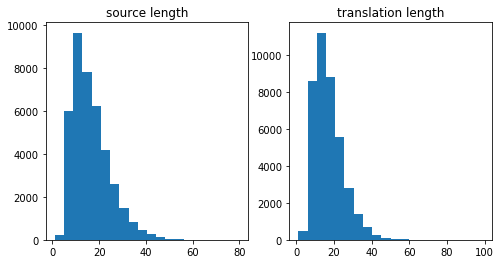

In [0]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


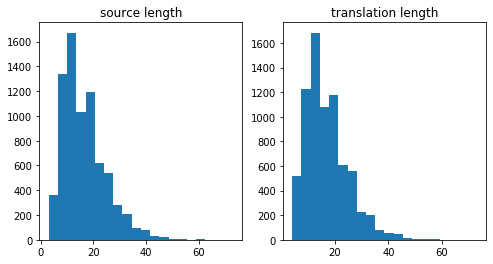

In [0]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 64]
	[.trg]:[torch.cuda.LongTensor of size 40x64 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 41x64 (GPU 0)]
torch.Size([41, 64]) torch.Size([40, 64])


In [0]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [0]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9305, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6762, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6762, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,938,474 trainable parameters


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

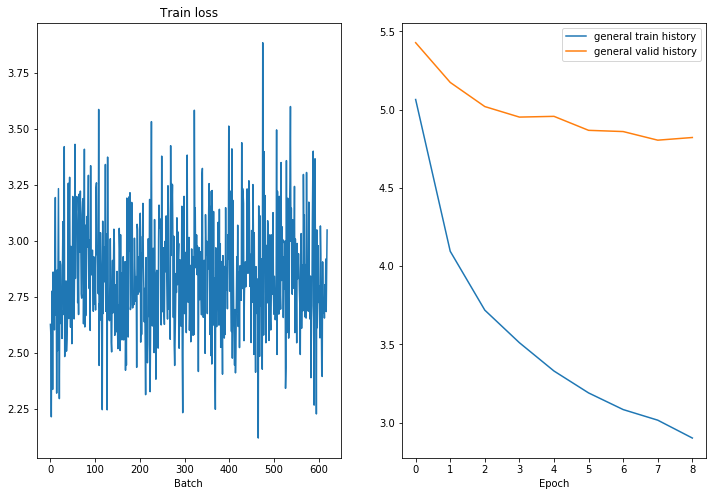

Epoch: 10 | Time: 4m 8s
	Train Loss: 2.840 | Train PPL:  17.116
	 Val. Loss: 4.886 |  Val. PPL: 132.403


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
batch = next(iter(test_iterator))

In [0]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: a kitchen is included .
Generated: wave a kitchen . dishwasher . .

Original: laundry services are available .
Generated: wave offers free parking . .



In [0]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [0]:
import tqdm

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

118it [00:07,  8.99it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.153750196899088

Baseline solution BLEU score is quite low. Try to achieve at least __40__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

Я взяла первые три подхода из списка предложенных:

### Approach 1: add BPE


Идея: используем всё ту же простую модель, но на этот раз применяем еще и BPE. Основная идея взята с семинара 3-ей недели (только там были German-English переводы).

In [0]:
#split_token = '<SPLIT_IT>'
split_token = '\n'

src_sentences = []
trg_sentences = []

# to present as a string, not as a list
def string_tokenize(x):
    return ' '.join(tokenize(x))

# I had to use this function to avoid errors  
def string_no_tok(x):
    return ' '.join(x)
 

In [0]:
# prepare data for bpe
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in train_data.examples:
        src_line, dst_line = line.src, line.trg
        f_src.write(string_no_tok(src_line) + split_token)
        f_dst.write(string_no_tok(dst_line) + split_token)
        
# Build vocabulary
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=5000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
# Apply bpe and prepare data
for dataset in [train_data, valid_data, test_data]:
    for line in dataset:
        line.src = (bpe['en'].process_line(string_no_tok(line.src))).split(" ")
        line.trg = (bpe['ru'].process_line(string_no_tok(line.trg))).split(" ")

Та же модель, но плюс BPE.

Количество эпох тоже возьмем такое же, как в базовом случае.

In [0]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9238, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6656, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6656, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

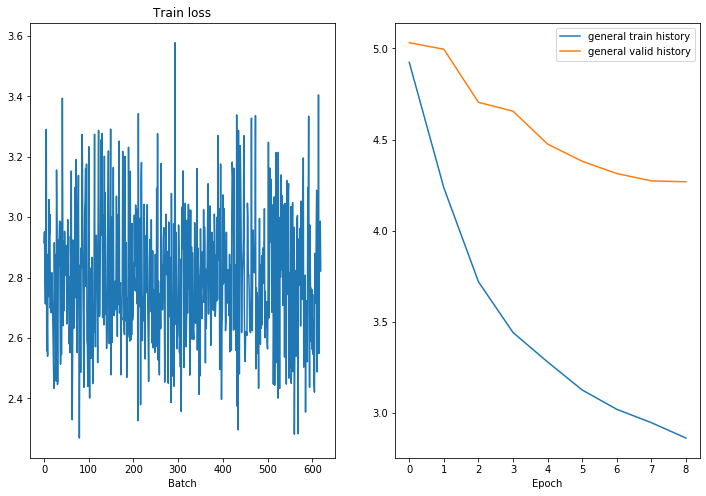

Epoch: 10 | Time: 4m 56s
	Train Loss: 2.797 | Train PPL:  16.395
	 Val. Loss: 4.199 |  Val. PPL:  66.590


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

batch = next(iter(test_iterator))

In [0]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

118it [00:08,  6.56it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

7.139845174644402

Результат не особо хороший, хуже, чем был до этого.

Попробуем использовать другой подход:

### Approach 2: CNN Encoder

Код ниже основан на этом ноутбуке: [Convolutional Sequence to Sequence Learning](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb)

Еще пара импортов:

In [0]:
import torch.nn.functional as F
import matplotlib.ticker as ticker

BATCH_SIZE из условия поменьше сделать пришлось как раз для этой модели.

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, device):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(100, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):        
        #create position tensor
        pos = torch.arange(0, src.shape[1]).unsqueeze(0).repeat(src.shape[0], 1).to(self.device)        
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
                
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
                
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
                
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
                
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
                
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
                
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale        
        return conved, combined

In [0]:
class DecoderCNN(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, pad_idx, device):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.pad_idx = pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(100, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
 
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
                
        combined = (conved_emb + embedded) * self.scale
                        
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        attention = F.softmax(energy, dim=2)
                    
        attended_encoding = torch.matmul(attention, encoder_combined)
                
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
                
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
                
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #create position tensor
        pos = torch.arange(0, trg.shape[1]).unsqueeze(0).repeat(trg.shape[0], 1).to(self.device)
                
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
                
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
                
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
                
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(conv_input.shape[0], 
                                  conv_input.shape[1], 
                                  self.kernel_size - 1).fill_(self.pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
                
            #pass through convolutional layer
            conved = conv(padded_conv_input)
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
                        
            #apply residual connection
            conved = (conved + conv_input) * self.scale
                        
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
                     
        output = self.out(self.dropout(conved))
                    
        return output, attention

In [0]:
class Seq2SeqCNN(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        encoder_conved, encoder_combined = self.encoder(src)
            
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        return output, attention

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())
  
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

Задаем параметры:

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 64
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
ENC_KERNEL_SIZE = 3
DEC_KERNEL_SIZE = 3 
PAD_IDX = TRG.vocab.stoi['<pad>']

encCNN = EncoderCNN(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
decCNN = DecoderCNN(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, PAD_IDX, device)

# dont forget to put the model to the right device
model = Seq2SeqCNN(encCNN, decCNN).to(device)

In [0]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [11]:
model.apply(init_weights)

Seq2SeqCNN(
  (encoder): EncoderCNN(
    (tok_embedding): Embedding(9250, 128)
    (pos_embedding): Embedding(100, 128)
    (emb2hid): Linear(in_features=128, out_features=64, bias=True)
    (hid2emb): Linear(in_features=64, out_features=128, bias=True)
    (convs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): DecoderCNN(
    (tok_embedding): Embedding(6736, 128)
    (pos_embedding): Embedding(100, 128)
    (emb2hid): Linear(in_features=128, out_features=64, bias=True)
    (hid2emb): Linear(in_features=64, out_features=128, bias=True)
    (attn_hid2emb): Linear(in_features=64, out_features=128, bias=True)
    (attn_emb2hid): Linear(in_features=128, out_features=64, bi

Количество эпох тоже можно оставить таким же, какое оно и было (10). Точнее, изначально пыталась сделать на 10 эпохах, но CNN запускается не очень хорошо, могут быть проблемы с памятью, так что оставила в итоге одну эпоху, тем более что результат уже получился хороший. 


In [0]:
train_history = []
valid_history = []

#N_EPOCHS = 10
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

Тут немного надо переписать функции train, evaluate:

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        
        output, _ = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
     
        loss = criterion(output, trg)   
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        if i >= 450:
            break
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    model.train()    
    epoch_loss = 0
    
    model.eval()   
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg) 
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

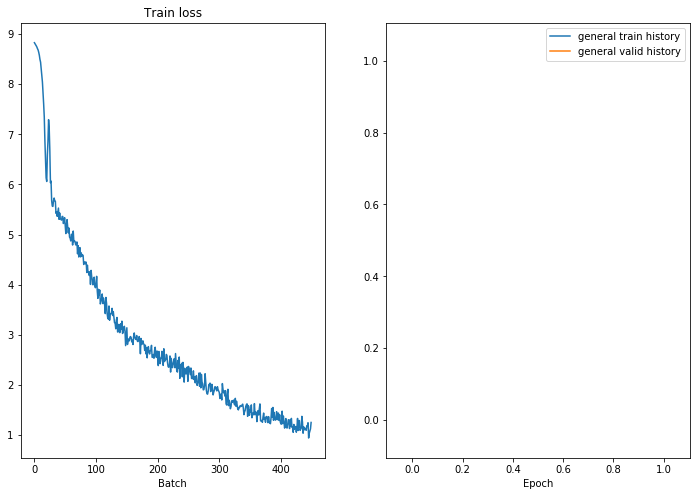

Epoch: 01 | Time: 0m 36s
	Train Loss: 2.098 | Train PPL:   8.152
	 Val. Loss: 0.778 |  Val. PPL:   2.177


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

На правом рисунке в клетке выше ничего не отрисовалось ввиду того, что эпоха всего одна.

Немного изменим еще пару функций:

In [0]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

batch = next(iter(test_iterator))

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output, _ = model(src, trg) 
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

118it [00:01, 102.90it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

34.15212601256127

Результат получился самый хороший (из всех 3 подходов), причем получен был быстрее всего (хватило всего одной эпохи).

### Approach 3: Attention

Здесь я возьму частично то, что было во второй домашней работе.


In [0]:
import random
import torch
from torch import nn
from torch.nn import functional as F

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, (hidden, cell) = self.rnn(embedded)
        return output, hidden, cell

In [0]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn = nn.Linear(in_features = enc_hid_dim + dec_hid_dim, out_features = dec_hid_dim)
        self.tanh = nn.Tanh()
        self.fc = nn.Linear(in_features = dec_hid_dim, out_features = 1)
        self.softmax = nn.Softmax(dim = 0)
        
    def forward(self, hidden, encoder_outputs):
        enc_len = encoder_outputs.shape[0]
        hidden = torch.tensor(hidden)

        #repeat previous decoder hidden state
        hiddens = hidden.expand(enc_len * hidden.shape[0], -1, -1)

        #concatenate
        concatenated_for_attn = torch.cat(
            [
            hiddens,
            encoder_outputs
            ],
            dim = 2)

        #find attn
        attn_1 = self.attn(concatenated_for_attn)

        #count energy
        energy = self.tanh(attn_1)

        #find a*_t = v * E_t as a result of dense layer
        attn_weights = self.fc(energy)

        #do softmax
        attn_res = self.softmax(attn_weights)

        #to dimension
        attn_res = attn_res.permute((1, 2, 0))
        
        return attn_res
    

In [0]:
class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU(input_size = emb_dim + dec_hid_dim, hidden_size  = dec_hid_dim, num_layers = 1, dropout = dropout)
        
        self.out = nn.Linear(in_features = dec_hid_dim * 2 + emb_dim, out_features = output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        # find attention vector
        attention_vector = self.attention(hidden, encoder_outputs)

        # transpose to get correct dimensions
        encoder_outputs = encoder_outputs.permute((1, 0, 2))
        
        #weighted source vector
        weights = torch.bmm(attention_vector, encoder_outputs)

        # to dimendion
        weights = weights.permute((1, 0, 2))

        #concatenation for GRU
        concatenated_for_gru = torch.cat(
            [
            embedded,
            weights
            ],
            dim = 2)

        output, hidden = self.rnn(concatenated_for_gru, hidden)

        #concatenation for the last linear layer
        concatenated_for_out = torch.cat(
            [
            embedded,
            weights,
            output
            ],
            dim = 2)

        prediction = self.out(concatenated_for_out.squeeze(0))

        return prediction, hidden


In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.dec_hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        enc_states, hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):

            output, hidden = self.decoder(input, hidden, enc_states)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs


In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attn = Attention(HID_DIM, HID_DIM)
dec = DecoderWithAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attn)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9192, 256)
    (rnn): LSTM(256, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (tanh): Tanh()
      (fc): Linear(in_features=512, out_features=1, bias=True)
      (softmax): Softmax(dim=0)
    )
    (embedding): Embedding(6685, 256)
    (rnn): GRU(768, 512, dropout=0.5)
    (out): Linear(in_features=1280, out_features=6685, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)


In [0]:
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

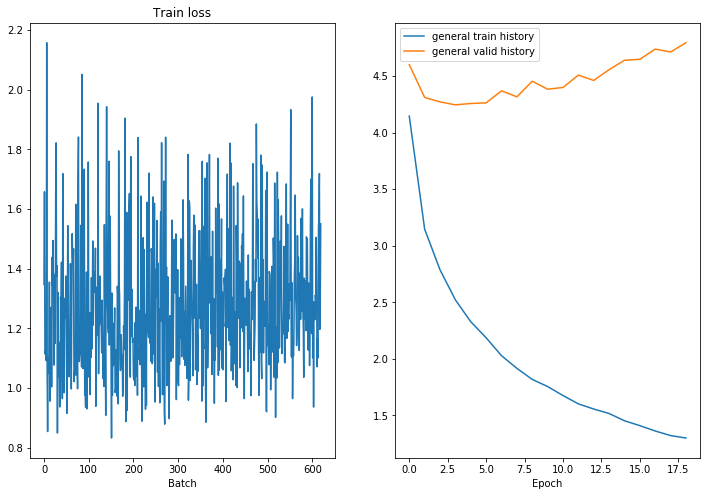

Epoch: 20 | Time: 7m 8s
	Train Loss: 1.275 | Train PPL:   3.580
	 Val. Loss: 4.856 |  Val. PPL: 128.545


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
batch = next(iter(test_iterator))

In [0]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: free parking is on site .
Generated: xiaoshan free parking is provided . . parking is available . .

Original: there is a 24 - hour front desk at the property .
Generated: xiaoshan front desk is open 24 hours a day . .



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [0]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
118it [00:12,  3.95it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

22.840977892884606

Как можно заметить, результат уже довольно неплохой (выше 20), но меньше, чем при использовании CNN Encoder.

#### Попробуем увеличить число эпох в последнем подходе.

Пусть у нас теперь 40 эпох вместо 20.

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attn = Attention(HID_DIM, HID_DIM)
dec = DecoderWithAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attn)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)


train_history = []
valid_history = []

N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


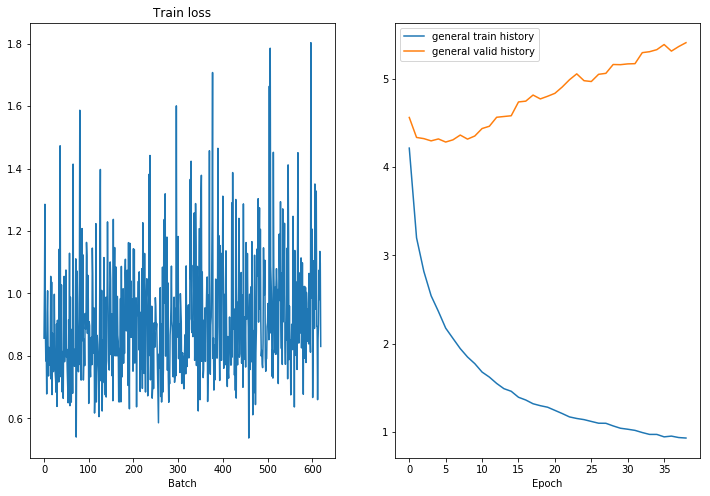

Epoch: 40 | Time: 7m 3s
	Train Loss: 0.919 | Train PPL:   2.506
	 Val. Loss: 5.395 |  Val. PPL: 220.319


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
batch = next(iter(test_iterator))

In [0]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: tér there is a 24 - hour front desk at the property . guests

Original: daily newspaper is also provided .
Generated: tér daily motel daily daily daily . . . . .



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [0]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
118it [00:12,  4.22it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

22.7438985544264

Результат не улучшился, наоборот стал чуть ниже, чем был до этого (это даже заметно по графику, видимо переобучился: вообще это довольно логично, но попробовать все равно стоило). 

Итак, до сих пор наилучшим подходом остается второй (CNN Encoder).

## Выводы

1. BPE

Подход довольно простой, качество дает не особо хорошее. Выполняется довольно долго (хотя и немного быстрее, чем Attention). В данном случае, качество получилось хуже, чем без применения BPE, однако в общем случае ничего такого, конечно, утверждать нельзя (может, тут просто не очень повезло).

2. CNN

На первый взгляд, CNN самый хороший алгоритм (результат мы получили самый высокий, да и обучение было самое быстрое, за счет как раз параллельности). Кроме того, уже на 1 эпохе результат оказался хороший.

С другой стороны, CNN требует очень много памяти, и порой выдает совсем уж странные ошибки. Кроме того, приходилось раньше прерывать обучение, не дойдя до конца всех батчей (на 450 прерывала).

В общем, из всех представленных выше подходов, CNNEncoder - это с одной стороны самый качественный, но в то же время самый проблемный подход.

3. Attention

Дает довольно неплохой результат (хотя и пониже, чем CNN), при этом спокойно выполняется, хотя и довольно долго. Для примера: 20 эпох занимают около 2,5 часов, 40 эпох - соответственно, порядка 5 часов. 

В то же время Attention, на мой взгляд, самый приятный из этих подходов: качество довольно хорошее, и он ведет себя вполне предсказуемо в отличие от CNN.

Итог: самый быстрый и дающий наивысший результат - CNN Encoder. Самый приятный, дающий приемлемое качество и работающий предсказуемо, хоть и долго - Attention. BPE же, использованный отдельно (без совмещения с каким-либо другим методом), сработал не очень хорошо.